# Reinforcement Learning 2025 - Final Assignment

**Authors:** Amit Ezer, Gal Yaacov Noy.

In [8]:
!pip install minigrid gymnasium matplotlib

In [9]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gymnasium as gym
import minigrid
from minigrid.wrappers import ImgObsWrapper, RGBImgPartialObsWrapper
from collections import deque
import os


MODELS_DIR = "saved_models"
os.makedirs(MODELS_DIR, exist_ok=True)


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [10]:
import torch
import torch.nn.functional as F

def preprocess(obs, target_size=(56, 56)):
    """
    Convert RGB observation(s) to normalized torch tensor(s) of shape:
      - (C, H, W) for single image
      - (N, C, H, W) for batch of images

    Resizes input to `target_size` using bilinear interpolation.
    """
    obs_tensor = torch.tensor(obs, dtype=torch.float32)

    if obs_tensor.ndim == 3:
        # Single image: (H, W, C) → (1, C, H, W)
        obs_tensor = obs_tensor.permute(2, 0, 1).unsqueeze(0) / 255.0
        obs_tensor = F.interpolate(obs_tensor, size=target_size, mode='bilinear', align_corners=False)
        return obs_tensor.squeeze(0)

    elif obs_tensor.ndim == 4:
        # Batched: (N, H, W, C) → (N, C, H, W)
        obs_tensor = obs_tensor.permute(0, 3, 1, 2) / 255.0
        obs_tensor = F.interpolate(obs_tensor, size=target_size, mode='bilinear', align_corners=False)
        return obs_tensor

    else:
        raise ValueError(f"Unexpected observation shape: {obs_tensor.shape}")


def create_env(env_name, **kwargs):
    env = gym.make(env_name, **kwargs)
    env = RGBImgPartialObsWrapper(env)
    env = ImgObsWrapper(env)
    return env

In [11]:
class MiniGridCNN(nn.Module):
    def __init__(self, output_dim=128, input_channels=3, input_size=56):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten()
        )
        
        # Compute the output size after the conv layers by passing a dummy input.
        with torch.no_grad():
            dummy_input = torch.zeros(1, input_channels, input_size, input_size)
            conv_out_size = self.conv(dummy_input).shape[1]

        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, output_dim),
            nn.ReLU()
        )
        
    def forward(self, x):
        return self.fc(self.conv(x))

## DoubleDQN

In [12]:
class QNetwork(nn.Module):
    def __init__(self, num_actions, feature_dim=128, input_size=56):
        super().__init__()
        self.encoder = MiniGridCNN(output_dim=feature_dim, input_size=input_size)
        self.q_head = nn.Linear(feature_dim, num_actions)

    def forward(self, x):
        features = self.encoder(x)
        return self.q_head(features)

In [13]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.stack(states).to(device),
            torch.stack(actions).to(device),
            torch.stack(rewards).to(device),
            torch.stack(next_states).to(device),
            torch.stack(dones).to(device),
        )

    def __len__(self):
        return len(self.buffer)

In [14]:
def select_action(model, state, epsilon, num_actions):
    """
    Selects an action using an epsilon-greedy strategy:
    - With probability `epsilon`, a random action is chosen (exploration).
    - With probability `1 - epsilon`, the action with the highest Q-value is chosen (exploitation).
    """
    if random.random() < epsilon:
        return torch.tensor([random.randint(0, num_actions - 1)], device=device)
    with torch.no_grad():
        q_values = model(state.unsqueeze(0))
        return q_values.argmax(dim=1)

In [15]:
def train_double_dqn(
    env_name="MiniGrid-Dynamic-Obstacles-16x16-v0",
    num_episodes=5000,
    max_steps=500,             
    batch_size=64,
    gamma=0.99,
    lr=1e-4,
    target_update_freq=500,
    replay_capacity=50_000,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.995,
    save_model=False,
):
    env = create_env(env_name)

    num_actions = env.action_space.n
    obs, _ = env.reset()
    input_size = obs.shape[0]

    # Models
    policy_net = QNetwork(num_actions, input_size=input_size).to(device)
    target_net = QNetwork(num_actions, input_size=input_size).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    replay_buffer = ReplayBuffer(capacity=replay_capacity)

    # Tracking
    episode_rewards = []
    episode_lengths = []
    losses = []
    epsilons = []
    global_step = 0
    epsilon = epsilon_start

    print(f"\n{'='*60}")
    print(f"TRAINING DOUBLE DQN ON {env_name.upper()}")
    print(f"{'='*60}")
    print(f"Episodes: {num_episodes} | Batch Size: {batch_size} | Learning Rate: {lr}")
    print(f"Gamma: {gamma} | Target Update: {target_update_freq} | Replay Capacity: {replay_capacity:,}")
    print(f"Epsilon: {epsilon_start} -> {epsilon_end} (decay: {epsilon_decay})")
    print(f"{'='*60}")

    for episode in range(num_episodes):
        obs, _ = env.reset()
        state = preprocess(obs).to(device)
        total_reward = 0
        steps = 0

        for _ in range(max_steps):
            action = select_action(policy_net, state, epsilon, num_actions)

            next_obs, reward, terminated, truncated, _ = env.step(action.item())
            next_state = preprocess(next_obs).to(device)
            done = terminated or truncated

            # Store transition
            transition = (
                state.cpu(),
                torch.tensor([action.item()], dtype=torch.long),
                torch.tensor([reward], dtype=torch.float32),
                next_state.cpu(),
                torch.tensor([done], dtype=torch.float32)
            )
            replay_buffer.push(transition)

            state = next_state
            total_reward += reward
            steps += 1
            global_step += 1

            # Train step
            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

                # Current Q-values for taken actions
                q_values = policy_net(states).gather(1, actions.view(-1, 1)).squeeze()

                with torch.no_grad():
                    # Double DQN: use policy network to select actions, target network to evaluate
                    next_actions = policy_net(next_states).argmax(dim=1, keepdim=True)
                    next_q_values = target_net(next_states).gather(1, next_actions).squeeze()
                    targets = rewards.squeeze() + gamma * next_q_values * (1 - dones.squeeze())

                loss = F.mse_loss(q_values, targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss.item())

            # Learn
            if global_step % target_update_freq == 0:
                target_net.load_state_dict(policy_net.state_dict())

            if done:
                break

        episode_rewards.append(total_reward)
        episode_lengths.append(steps)
        epsilons.append(epsilon)

        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        if episode % 100 == 0:
            recent_rewards = np.mean(episode_rewards[-50:]) if len(episode_rewards) >= 50 else np.mean(episode_rewards)
            recent_steps = np.mean(episode_lengths[-50:]) if len(episode_lengths) >= 50 else np.mean(episode_lengths)
            recent_loss = np.mean(losses[-100:]) if len(losses) >= 100 else (np.mean(losses) if losses else 0)
            print(f"[Double DQN] Ep {episode:4d} | Reward: {total_reward:6.2f} | Avg Reward: {recent_rewards:6.2f} | Steps: {steps:3d} | Avg Steps: {recent_steps:5.1f} | Epsilon: {epsilon:.3f} | Loss: {recent_loss:.4f}")

    env.close()

    print(f"\n{'='*60}")
    print(f"TRAINING COMPLETED!")
    print(f"Final Average Reward (last 100 episodes): {np.mean(episode_rewards[-100:]):.3f}")
    print(f"Final Average Steps (last 100 episodes): {np.mean(episode_lengths[-100:]):.1f}")
    print(f"Total Training Steps: {global_step:,}")
    print(f"{'='*60}")

    if save_model:
        model_path = os.path.join(MODELS_DIR, f"{env_name.replace('/', '_')}_double_dqn.pt")
        torch.save(policy_net.state_dict(), model_path)
        print(f"Policy model saved to: {model_path}")

    return {
        "name": "Double DQN",
        "rewards": episode_rewards,
        "steps": episode_lengths,
        "losses": losses,
        "epsilons": epsilons
    }


## PPO

In [16]:
class ActorCritic(nn.Module):
    def __init__(self, num_actions, input_size=84, feature_dim=128):
        super().__init__()
        self.encoder = MiniGridCNN(output_dim=feature_dim, input_size=input_size)
        self.actor = nn.Linear(feature_dim, num_actions)
        self.critic = nn.Linear(feature_dim, 1)

    def forward(self, x):
        features = self.encoder(x)
        return self.actor(features), self.critic(features)

    def get_action(self, state):
        logits, _ = self.forward(state)
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()
        return action, dist.log_prob(action), dist.entropy()

    def evaluate(self, obs, actions):
        logits, values = self.forward(obs)
        dist = torch.distributions.Categorical(logits=logits)
        log_probs = dist.log_prob(actions)
        entropy = dist.entropy()
        return log_probs, values.squeeze(), entropy

In [17]:
def compute_gae(rewards, values, dones, gamma=0.99, lam=0.95):
    """
    rewards: list of tensors (num_envs,)
    values: list of tensors (num_envs,) + 1 bootstrap value
    dones: list of tensors (num_envs,)
    returns: tensor of shape (T, num_envs)
    """
    advs = []
    gae = torch.zeros_like(rewards[0]).to(device)

    for t in reversed(range(len(rewards))):
        delta = rewards[t] + gamma * values[t + 1] * (1 - dones[t]) - values[t]
        gae = delta + gamma * lam * (1 - dones[t]) * gae
        advs.insert(0, gae)

    return torch.stack(advs).to(device)

In [18]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from gymnasium.vector import SyncVectorEnv

def train_ppo(
    env_name="MiniGrid-Dynamic-Obstacles-6x6-v0",
    num_episodes=3000,
    max_steps=2048,
    num_envs=8,
    gamma=0.99,
    lam=0.95,
    clip_eps=0.2,
    lr=3e-4,
    update_epochs=10,
    minibatch_size=64,
    entropy_coef=0.01,
    vf_coef=0.5,
    save_model=False
):
    # Initialize environments
    envs = SyncVectorEnv([lambda: create_env(env_name) for _ in range(num_envs)])
    num_actions = envs.single_action_space.n

    obs, _ = envs.reset()
    states = preprocess(obs, target_size=(56, 56)).to(device)  # (N, C, H, W)
    input_size = states.shape[1:][1]

    # Initialize model and optimizer
    model = ActorCritic(num_actions=num_actions, input_size=input_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Tracks
    episode_rewards, episode_lengths, losses = [], [], []
    global_step = 0
    finished_episodes = 0

    print(f"\n{'='*60}")
    print(f"TRAINING PPO ON {env_name.upper()} WITH {num_envs} ACTORS")
    print(f"{'='*60}")

    while finished_episodes < num_episodes:
        # Rollout storage
        log_probs, actions, rewards, values, dones, state_buffer = [], [], [], [], [], []
        ep_rewards = np.zeros(num_envs)
        ep_lengths = np.zeros(num_envs)

        for _ in range(max_steps):
            with torch.no_grad():
                action, log_prob, _ = model.get_action(states)   # action: (num_envs,)
                _, value = model(states)                         # value: (num_envs, 1)

            # Step all environments
            next_obs, reward, terminated, truncated, _ = envs.step(action.cpu().numpy())
            done = np.logical_or(terminated, truncated)
            next_states = preprocess(next_obs, target_size=(56, 56)).to(device)

            # Save transition
            state_buffer.append(states)
            actions.append(action.to(device))
            log_probs.append(log_prob)
            rewards.append(torch.from_numpy(reward).float().to(device))
            values.append(value.squeeze(-1))
            dones.append(torch.from_numpy(done).float().to(device))

            ep_rewards += reward
            ep_lengths += (~done).astype(int)
            finished_episodes += int(np.sum(done))
            global_step += num_envs

            states = next_states
            if finished_episodes >= num_episodes:
                break

        # Bootstrap value for final state
        with torch.no_grad():
            _, next_value = model(states)
        values.append(next_value.squeeze(-1))  # shape: (num_envs,)

        # Compute advantages and returns
        advantages = compute_gae(rewards, values, dones, gamma, lam)  # shape: (T, num_envs)
        returns = advantages + torch.stack(values[:-1])               # shape: (T, num_envs)

        # Flatten rollout data: each entry is (T, N)
        dataset = list(zip(
            torch.cat(state_buffer),            # (T*N, C, H, W)
            torch.cat(actions),                 # (T*N,)
            torch.cat(log_probs),               # (T*N,)
            returns.flatten(),                  # (T*N,)
            advantages.flatten()                # (T*N,)
        ))

        # === PPO Update ===
        for _ in range(update_epochs):
            random.shuffle(dataset)
            for i in range(0, len(dataset), minibatch_size):
                batch = dataset[i:i + minibatch_size]
                if len(batch) < minibatch_size:
                    continue

                b_states, b_actions, b_old_log_probs, b_returns, b_advs = zip(*batch)
                b_states = torch.stack(b_states).to(device)
                b_actions = torch.stack(b_actions).to(device)
                b_old_log_probs = torch.stack(b_old_log_probs).to(device)
                b_returns = torch.stack(b_returns).to(device)
                b_advs = torch.stack(b_advs).to(device)

                # Forward pass
                log_probs, values, entropy = model.evaluate(b_states, b_actions)
                log_probs = log_probs.squeeze(-1)
                values = values.squeeze(-1)
                b_old_log_probs = b_old_log_probs.squeeze(-1)
                b_advs = b_advs.squeeze(-1)
                b_returns = b_returns.squeeze(-1)

                # PPO clipped loss
                ratio = torch.exp(log_probs - b_old_log_probs)
                surr1 = ratio * b_advs
                surr2 = torch.clamp(ratio, 1 - clip_eps, 1 + clip_eps) * b_advs
                policy_loss = -torch.min(surr1, surr2).mean()
                value_loss = F.mse_loss(values, b_returns)
                loss = policy_loss + vf_coef * value_loss - entropy_coef * entropy.mean()

                # Optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss.item())

        # === Logging ===
        episode_rewards.extend(ep_rewards.tolist())
        episode_lengths.extend(ep_lengths.tolist())
        if finished_episodes % 100 < num_envs:
            avg_reward = np.mean(episode_rewards[-50:])
            avg_len = np.mean(episode_lengths[-50:])
            avg_loss = np.mean(losses[-100:]) if losses else 0
            print(f"[PPO] Ep {finished_episodes:4d} | Avg Reward: {avg_reward:.2f} | Steps: {avg_len:.1f} | Loss: {avg_loss:.4f}")

    envs.close()
    print(f"\n{'='*60}\nTRAINING COMPLETED!\n{'='*60}")

    if save_model:
        model_path = os.path.join(MODELS_DIR, f"{env_name.replace('/', '_')}_ppo.pt")
        torch.save(model.state_dict(), model_path)
        print(f"PPO model saved to: {model_path}")

    return {
        "name": "PPO",
        "rewards": episode_rewards,
        "steps": episode_lengths,
        "losses": losses,
    }

In [19]:
def plot_training_results(logs, window=50, title="Double DQN Training Results"):
    """Plot training results with moving averages like in midterm."""
    def moving_average(data, window):
        if len(data) < window:
            return data
        return np.convolve(data, np.ones(window)/window, mode='valid')

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(title, fontsize=16, fontweight='bold')

    # Episode Rewards
    axes[0, 0].plot(logs["rewards"], alpha=0.3, label="Raw", color='blue')
    if len(logs["rewards"]) >= window:
        smooth_rewards = moving_average(logs["rewards"], window)
        axes[0, 0].plot(range(window-1, len(logs["rewards"])), smooth_rewards,
                       label=f"Moving Avg ({window})", linewidth=2, color='red')
    axes[0, 0].set_title("Episode Rewards")
    axes[0, 0].set_xlabel("Episode")
    axes[0, 0].set_ylabel("Reward")
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)

    # Episode Steps
    axes[0, 1].plot(logs["steps"], alpha=0.3, label="Raw", color='green')
    if len(logs["steps"]) >= window:
        smooth_steps = moving_average(logs["steps"], window)
        axes[0, 1].plot(range(window-1, len(logs["steps"])), smooth_steps,
                       label=f"Moving Avg ({window})", linewidth=2, color='orange')
    axes[0, 1].set_title("Episode Length")
    axes[0, 1].set_xlabel("Episode")
    axes[0, 1].set_ylabel("Steps")
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)

    # Training Loss
    if logs["losses"]:
        axes[1, 0].plot(logs["losses"], alpha=0.6, color='purple')
        if len(logs["losses"]) >= window:
            smooth_loss = moving_average(logs["losses"], window)
            axes[1, 0].plot(range(window-1, len(logs["losses"])), smooth_loss,
                           label=f"Moving Avg ({window})", linewidth=2, color='red')
            axes[1, 0].legend()
    axes[1, 0].set_title("Training Loss")
    axes[1, 0].set_xlabel("Training Step")
    axes[1, 0].set_ylabel("TD Loss")
    axes[1, 0].grid(alpha=0.3)

    # Epsilon Decay
    if "epsilons" in logs and logs["epsilons"]:
        axes[1, 1].plot(logs["epsilons"], color='brown', linewidth=2)
        axes[1, 1].set_title("Exploration Rate (Epsilon)")
        axes[1, 1].set_xlabel("Episode")
        axes[1, 1].set_ylabel("Epsilon")
        axes[1, 1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

def print_performance_summary(logs):
    """Print performance summary like in midterm."""
    print(f"\n{'='*60}")
    print(f"PERFORMANCE SUMMARY - {logs['name'].upper()}")
    print(f"{'='*60}")

    final_rewards = np.mean(logs["rewards"][-100:]) if len(logs["rewards"]) >= 100 else np.mean(logs["rewards"])
    best_rewards = max([np.mean(logs["rewards"][i:i+100]) for i in range(len(logs["rewards"])-99)]) if len(logs["rewards"]) >= 100 else max(logs["rewards"])
    final_steps = np.mean(logs["steps"][-100:]) if len(logs["steps"]) >= 100 else np.mean(logs["steps"])
    final_loss = np.mean(logs["losses"][-1000:]) if len(logs["losses"]) >= 1000 else (np.mean(logs["losses"]) if logs["losses"] else 0)

    print(f"Final Performance (last 100 episodes):")
    print(f"  Average Reward: {final_rewards:.3f}")
    print(f"  Average Steps: {final_steps:.1f}")
    print(f"  Training Loss: {final_loss:.4f}")
    print(f"\nBest Performance:")
    print(f"  Best 100-episode Average Reward: {best_rewards:.3f}")
    print(f"  Total Episodes: {len(logs['rewards'])}")
    print(f"  Total Training Steps: {len(logs['losses']):,}")
    print(f"{'='*60}")

EXPERIMENTS = {
    'Double DQN': train_double_dqn,
    'PPO': train_ppo
}

def run_experiment(name, **kwargs):
    """Run complete experiment: train agent, analyze, and plot."""
    # Train agent
    logs = EXPERIMENTS[name](**kwargs)

    # Analyze and visualize
    print_performance_summary(logs)
    plot_training_results(logs)

    return logs


TRAINING DOUBLE DQN ON MINIGRID-DYNAMIC-OBSTACLES-5X5-V0
Episodes: 100 | Batch Size: 64 | Learning Rate: 0.0001
Gamma: 0.99 | Target Update: 500 | Replay Capacity: 50,000
Epsilon: 1.0 -> 0.05 (decay: 0.995)
[Double DQN] Ep    0 | Reward:  -1.00 | Avg Reward:  -1.00 | Steps:  23 | Avg Steps:  23.0 | Epsilon: 0.995 | Loss: 0.0000

TRAINING COMPLETED!
Final Average Reward (last 100 episodes): -1.000
Final Average Steps (last 100 episodes): 6.5
Total Training Steps: 655
Policy model saved to: saved_models\MiniGrid-Dynamic-Obstacles-5x5-v0_double_dqn.pt

PERFORMANCE SUMMARY - DOUBLE DQN
Final Performance (last 100 episodes):
  Average Reward: -1.000
  Average Steps: 6.5
  Training Loss: 0.0339

Best Performance:
  Best 100-episode Average Reward: -1.000
  Total Episodes: 100
  Total Training Steps: 592


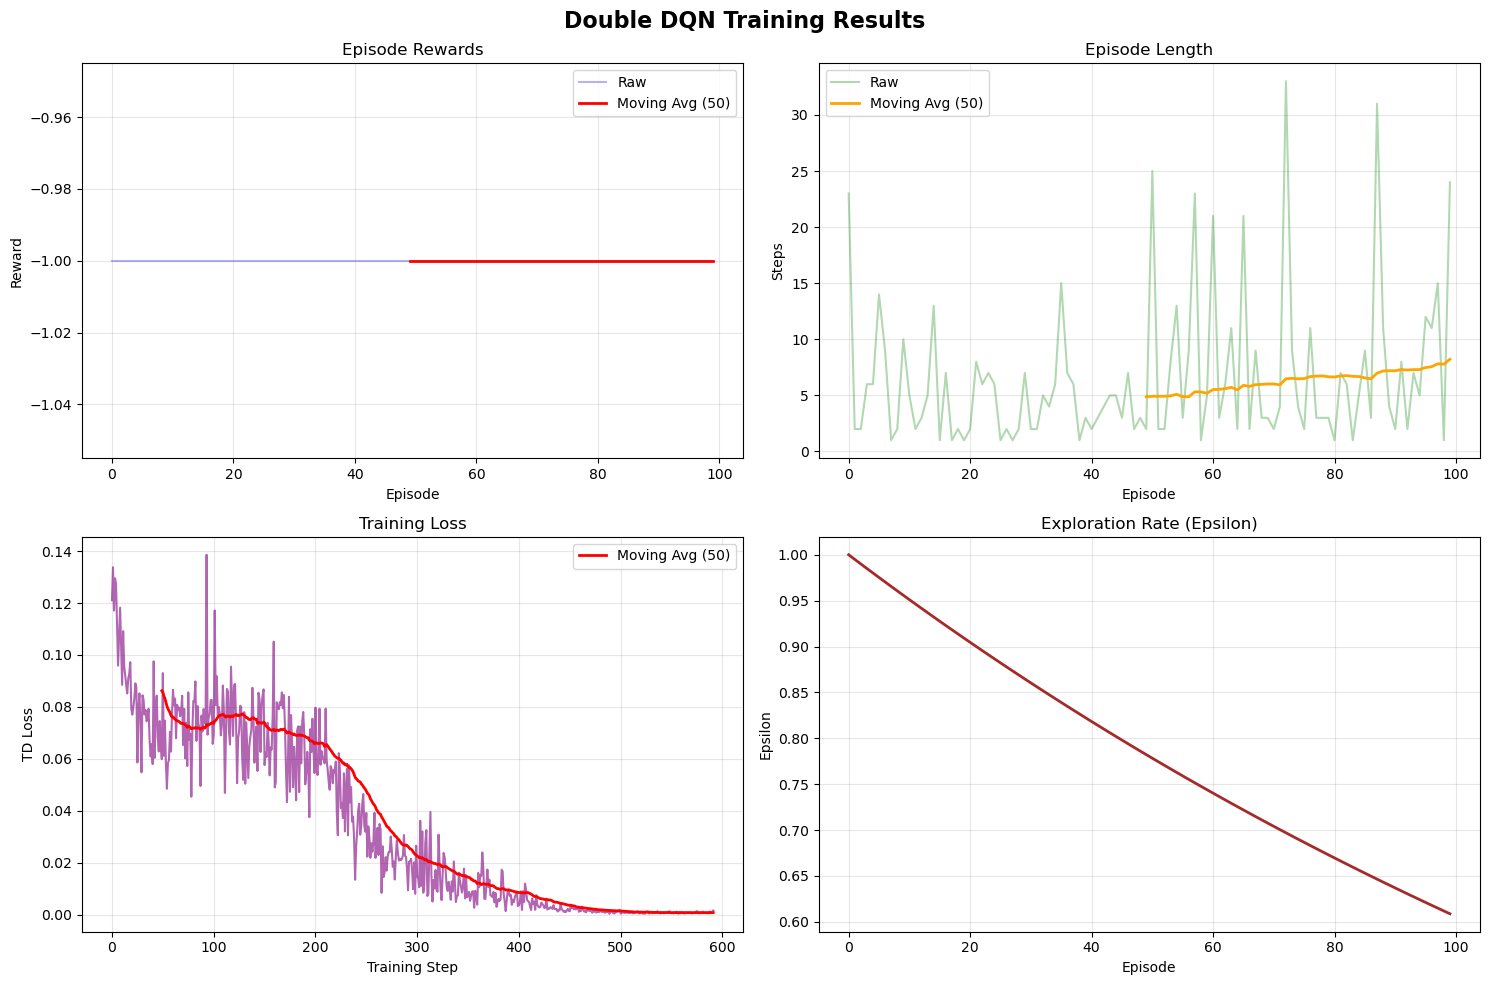

In [ ]:
dqn_logs = run_experiment('Double DQN', env_name="MiniGrid-Dynamic-Obstacles-5x5-v0", num_episodes=1000, max_steps=100, batch_size=64, save_model=True)


TRAINING PPO ON MINIGRID-DYNAMIC-OBSTACLES-6X6-V0 WITH 8 ACTORS
[PPO] Ep  101 | Avg Reward: -12.62 | Steps: 73.4 | Loss: 0.8282

TRAINING COMPLETED!
PPO model saved to: saved_models\MiniGrid-Dynamic-Obstacles-6x6-v0_ppo.pt

PERFORMANCE SUMMARY - PPO
Final Performance (last 100 episodes):
  Average Reward: -12.625
  Average Steps: 73.4
  Training Loss: 0.8282

Best Performance:
  Best 100-episode Average Reward: -10.000
  Total Episodes: 8
  Total Training Steps: 100


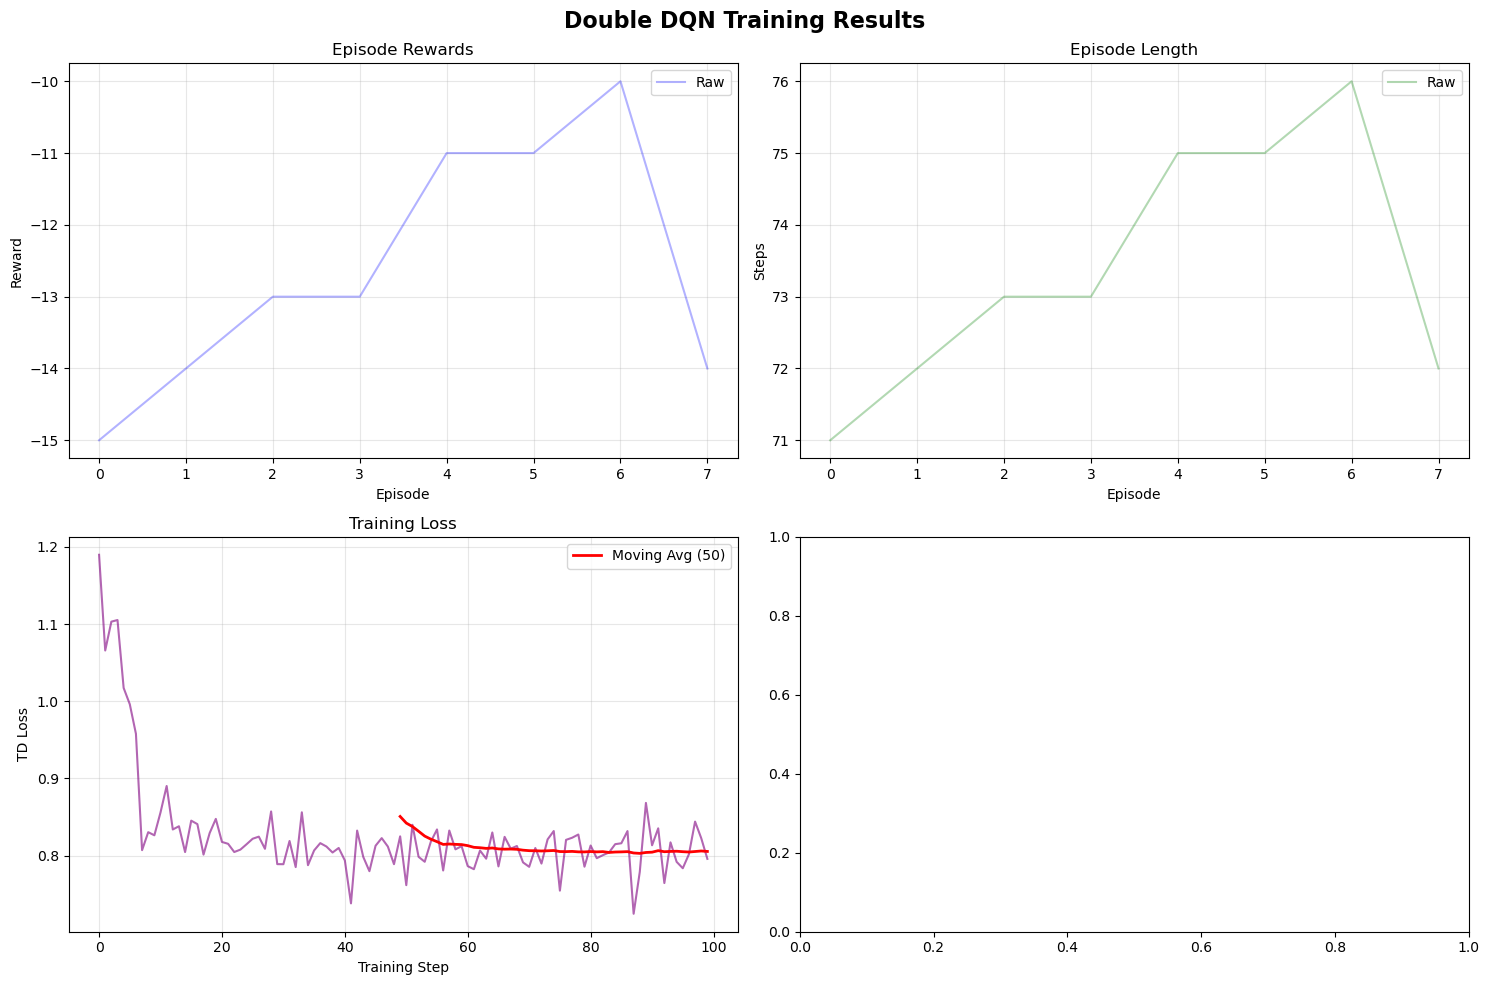

In [ ]:
ppo_logs = run_experiment('PPO',
                          env_name="MiniGrid-Dynamic-Obstacles-6x6-v0",
    num_episodes=3000,
    max_steps=2048, 
    gamma=0.99,
    lam=0.95, 
    clip_eps=0.2,
    lr=3e-4, 
    update_epochs=10,
    minibatch_size=64,
    entropy_coef=0.01,
    vf_coef=0.5,
    save_model=True
)